In [1]:
import pandas as pd
import numpy as np
import os
import csv
import re
import matplotlib.pyplot as plt

from typing import Type, Union, List

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline

# The Pipeline
1. Read formatted data as DF
2. Add salary tiers to DF
3. Retain desired subset of features and remove rest from DF
4. Split data into train/test
5. Determine transformations for data (numerical/categorical)
6. Map numerical/categorical transformations to appropriate features using ColumnTransformer
7. Add transformations to a sklearn Pipeline
8. Add a predictive model to the same Pipeline
9. Fit model on training data
10. Cross-validate
11. Score on test data

In [2]:
debug = True
src_dir = os.getcwd()
data_dir = os.path.join(src_dir, "Data")

In [3]:
merged_data_file = os.path.join(data_dir, "nba_stats_sal_merged_1990_2017.csv")
merged_data = pd.read_csv(merged_data_file)

In [4]:
if debug: 
    print("Input Data:")
    print(merged_data.iloc[list(range(5)) + list(range(-5, 0)), 
                   list(range(5)) + list(range(-5, 0))])

Input Data:
       Season End             Player Pos  Age   Tm  BLK  TOV   PF   PTS  \
0            1990         Mark Acres   C   27  ORL   25   70  248   362   
1            1990      Michael Adams  PG   27  DEN    3  141  133  1221   
2            1990       Mark Aguirre  SF   30  DET   19  121  201  1099   
3            1990        Danny Ainge  PG   30  SAC   18  185  238  1342   
4            1990        Mark Alarie  PF   26  WSB   39  101  219   860   
10639        2017        Cody Zeller  PF   24  CHO   58   65  189   639   
10640        2017       Tyler Zeller   C   27  BOS   21   20   61   178   
10641        2017  Stephen Zimmerman   C   20  ORL    5    3   17    23   
10642        2017        Paul Zipser  SF   22  CHI   16   40   78   240   
10643        2017        Ivica Zubac   C   19  LAL   33   30   66   284   

         Salary  
0        437000  
1        825000  
2       1115000  
3        725000  
4        500000  
10639  12584270  
10640   1709538  
10641   1312611  


In [5]:
merged_data.dtypes

Season End      int64
Player         object
Pos            object
Age             int64
Tm             object
G               int64
GS              int64
MP              int64
PER           float64
TS%           float64
3PAr          float64
FTr           float64
ORB%          float64
DRB%          float64
TRB%          float64
AST%          float64
STL%          float64
BLK%          float64
TOV%          float64
USG%          float64
OWS           float64
DWS           float64
WS            float64
WS/48         float64
OBPM          float64
DBPM          float64
BPM           float64
VORP          float64
FG              int64
FGA             int64
FG%           float64
3P              int64
3PA             int64
3P%           float64
2P              int64
2PA             int64
2P%           float64
eFG%          float64
FT              int64
FTA             int64
FT%           float64
ORB             int64
DRB             int64
TRB             int64
AST             int64
STL       

## Preprocessing Steps
- Already took care of null data (when reading from original CSVs and merging)
- Try different normalization, standardization techniques and see effect on performance
- The only categorical variable to be encoded is Position; not using Team unfortunately b/c a) teams have changed and b) some players played for multiple teams, and thus have TOT as their team. Note that this variable is not ordinal, it's nominal. Also, beware multicollinearity.
- Split data by year, do scaling on separate DataFrames, then concatenate.
- Write different scaled data to different CSVs.

## Generating Salary Tiers

In [6]:
num_tiers = 5

In [7]:
def add_salary_tiers(num_tiers: int, merged_data: pd.DataFrame):
    # Compute max salaries per year
    salary_maxes = merged_data.groupby('Season End')['Salary'].max().to_dict()
    # Append salary tiers per player in a new column
    player_tiers = []
    for index, row in merged_data[['Season End', 'Salary']].iterrows():
        # +1 so we have num_tiers tiers (so the max falls in the highest tier)
        player_tiers.append(int(row['Salary'] / (salary_maxes[row['Season End']]+1) * num_tiers))
    if not 'Salary Tier' in merged_data.columns: 
        merged_data.insert(len(merged_data.columns), 'Salary Tier', pd.Series(player_tiers))
    else:
        merged_data['Salary Tier'] = pd.Series(player_tiers)

In [8]:
add_salary_tiers(num_tiers, merged_data)
if debug: 
    print("Merged With Salary Tier:")
    print(merged_data.iloc[list(range(5)) + list(range(-5, 0)), 
                   list(range(5)) + list(range(-5, 0))])

Merged With Salary Tier:
       Season End             Player Pos  Age   Tm  TOV   PF   PTS    Salary  \
0            1990         Mark Acres   C   27  ORL   70  248   362    437000   
1            1990      Michael Adams  PG   27  DEN  141  133  1221    825000   
2            1990       Mark Aguirre  SF   30  DET  121  201  1099   1115000   
3            1990        Danny Ainge  PG   30  SAC  185  238  1342    725000   
4            1990        Mark Alarie  PF   26  WSB  101  219   860    500000   
10639        2017        Cody Zeller  PF   24  CHO   65  189   639  12584270   
10640        2017       Tyler Zeller   C   27  BOS   20   61   178   1709538   
10641        2017  Stephen Zimmerman   C   20  ORL    3   17    23   1312611   
10642        2017        Paul Zipser  SF   22  CHI   40   78   240   1312611   
10643        2017        Ivica Zubac   C   19  LAL   30   66   284   1312611   

       Salary Tier  
0                0  
1                0  
2                1  
3         

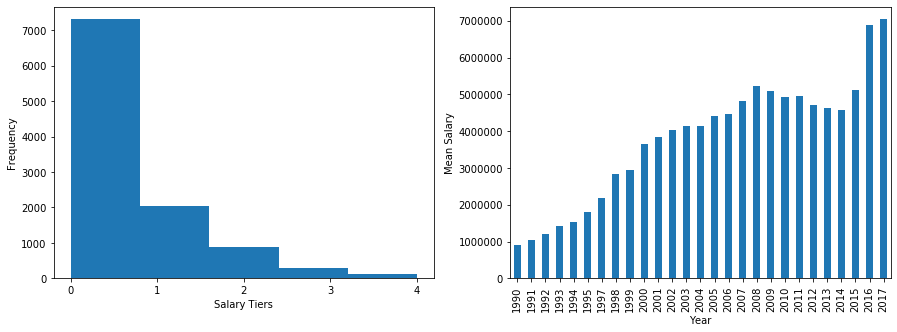

In [9]:
def plot_salary_info(merged_sal_tier: pd.DataFrame):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(15, 5)
    merged_data['Salary Tier'].plot.hist(ax=ax1, bins=num_tiers, xticks=[0, 1, 2, 3, 4])
    ax1.set_xlabel("Salary Tiers")
    merged_data.groupby('Season End')['Salary'].mean().sort_index().plot.bar(ax=ax2)
    ax2.set_xlabel("Year")
    ax2.set_ylabel("Mean Salary")
    plt.show()

if debug: plot_salary_info(merged_data)

In [10]:
# Export data

# Scikit-learn Pipeline

## 80/20 Train-Test Split

In [11]:
if debug: print("Merged w_sal columns:\n", merged_data.columns)

Merged w_sal columns:
 Index(['Season End', 'Player', 'Pos', 'Age', 'Tm', 'G', 'GS', 'MP', 'PER',
       'TS%', '3PAr', 'FTr', 'ORB%', 'DRB%', 'TRB%', 'AST%', 'STL%', 'BLK%',
       'TOV%', 'USG%', 'OWS', 'DWS', 'WS', 'WS/48', 'OBPM', 'DBPM', 'BPM',
       'VORP', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%', '2P', '2PA', '2P%',
       'eFG%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK',
       'TOV', 'PF', 'PTS', 'Salary', 'Salary Tier'],
      dtype='object')


In [12]:
#features to omit
def construct_final_df(merged_w_sal: pd.DataFrame, to_omit: List[str]):
    # Check that to_omit contains valid features
    if all(feature in merged_w_sal.columns for feature in to_omit):
        return merged_w_sal[[feature for feature in merged_w_sal.columns if not feature in to_omit]]
    else:
        raise ValueError("to_omit must contain valid features")

In [13]:
merged_data_final = construct_final_df(merged_data, ['Player', 'Tm', 'Salary'])
#merged_data_final = construct_final_df(merged_data_final, 
#                                       ['Pos', 'G', 'GS', 'MP', '3PAr', 'FTr', 'ORB%', 'DRB%', 'TOV%', 'WS/48',
#                                       'OBPM', 'DBPM', 'VORP', 'FG', 'FGA', '3P', '3PA', '3P%', '2P', '2PA', '2P%',
#                                       'FTA', 'ORB', 'DRB', 'PF'])
#these two lines always in supervisedlearning, data in y, 
y = merged_data_final.pop('Salary Tier')
#train fiiting, test scoring
X_train, X_test, y_train, y_test = train_test_split(merged_data_final, y, test_size=0.2)
if debug: 
    print("X_train shape: {} | y_train shape: {}".format(X_train.shape, y_train.shape))
    print("X_test shape: {} | y_test shape: {}".format(X_test.shape, y_test.shape))

X_train shape: (8515, 48) | y_train shape: (8515,)
X_test shape: (2129, 48) | y_test shape: (2129,)


## One Hot Encoding of Pos and Multicollinearity
We see that we don't need to worry about multicollinearity from these values.

In [14]:
if debug: 
    if 'Pos' in X_train.columns:
        print(X_train['Pos'].value_counts())

PF       1821
C        1751
PG       1649
SG       1635
SF       1537
SG-SF      24
SF-SG      19
PG-SG      18
PF-C       16
SG-PG      13
PF-SF      10
C-PF       10
SF-PF       8
SG-PF       3
PG-SF       1
Name: Pos, dtype: int64


In [15]:
# For reference, note that Transformers don't like 1D numpy arrays
#ohe = OneHotEncoder(sparse=False)
#print(ohe.fit_transform(X_train['Pos'].values.reshape(-1, 1)).shape)

### Categorical Transformation Pipeline
We will use a ColumnTransformer to fit transformations in parallel rather than run `cat_pipe.fit_transform(cat_Xtrain)` and `num_pipe.fit_transform(num_Xtrain)` ourselves sequentially.

In [16]:
# TransformerMixin: Need to implem fit and transform, we get fit_transform which invokes both
# BaseEstimator: We get get_params and set_params
class YearlyScaler(BaseEstimator, TransformerMixin):
    """
    Performs a Scaler Transform on the input DataFrame by year (groupby split-apply-combine strategy).
    
    Parameters
    ----------
    year_col : The name of the column containing years (to use for splitting)
    scaler : Some kind of Transformer
    return_df : Return a pd.Dataframe if True
    """
    def __init__(self, year_col: str, scaler: Type[Union[BaseEstimator, TransformerMixin]], 
                 return_df: bool = False):
        # TODO: FOR SOME FUCKING REASON THESE CAN'T BE MANGLED...
        self.scaler = scaler
        self.year_col = year_col
        self.return_df = return_df
    
    def fit(self, X: pd.DataFrame, y=None):
        """
        Parameters
        ----------
        X : DataFrame, shape [n_samples, n_features]
            The data to fit.
        y : Ignored
        
        Returns
        -------
        self: object
            Fitted scaler
        """
        # TODO: ...BUT THESE CAN...
        # Omit the groupby column
        self._columns = [col for col in X.columns.values if col != self.year_col]
        
        return self
    
    def transform(self, X: pd.DataFrame) -> Union[pd.DataFrame, np.ndarray]:
        """
        Parameters
        ----------
        X : DataFrame, shape [n_samples, n_features]
            The data used to scale along the features axis.
            
        Returns
        -------
        X_tr : array-like, shape [n_samples, n_features]
            Transformed array.
        """
        # Apply the self._scaler transform on all the numerical columns grouped by the Year column
        # Remove the scaled Year column (iloc[:, 1:] says all rows, ignore 0th column, which is Year)
        # Will give us a multi-indexed DF with the years as the 0-level index
        X_tr = X[[self.year_col]+self._columns].groupby(self.year_col).apply(
            lambda x, scaler=self.scaler: pd.DataFrame(scaler.fit_transform(x)).iloc[:, 1:])
        # Drop the year index
        X_tr.index = X_tr.index.droplevel(0)
        
        return X_tr if self.return_df else X_tr.to_numpy()

In [17]:
def construct_transformer(X_train: pd.DataFrame, 
                          scaler: Type[Union[BaseEstimator, TransformerMixin]],
                          year_col: str, n_jobs: int = None) -> ColumnTransformer:
    """
    n_jobs: -1 means use all processors. None means use 1.
    """
    # Get column types(help determine if categorical)
    kinds = np.array([dt.kind for dt in X_train.dtypes])
    all_columns = X_train.columns.values
    #numpy stuff, create mask
    is_num = kinds != 'O'
    num_cols = all_columns[is_num]
    cat_cols = all_columns[~is_num]

    # Define labeled categorical transformation steps
    # Dense matrix for potential time/space complexity
    # When encountering unknown labels (for test transform), ignore them
    cat_ohe_step = ('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore')) 

    # Put the categorical transformations in a Pipeline to be executed sequentially
    cat_steps = [cat_ohe_step]
    cat_pipe = Pipeline(cat_steps)

    # Define labeled numerical transformation steps
    num_scale_step = ('scale', YearlyScaler(year_col, scaler(), return_df=True))

    # Would do the following if creating a Pipeline to feed to ColumnTransformer
    # Put the numerical transformations in a Pipeline also
    num_steps = [num_scale_step]
    num_pipe = Pipeline(steps=num_steps)

    cat_col_transformers = ('cat', cat_pipe, cat_cols)
    num_col_transformers = ('num', num_pipe, num_cols)

    by_col_transformers = [cat_col_transformers, num_col_transformers]

    # Create ColumnTransformer which will apply transformations in parallel where possible
    col_transformer = ColumnTransformer(transformers=by_col_transformers, n_jobs=n_jobs)
    # We pass the whole training DataFrame because the transformers know which Pipelines
    # to apply to which columns (specified in the 'transformers' list)
    
    return col_transformer

## Make the following a new notebook

In [18]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, MaxAbsScaler, RobustScaler
n_jobs = -1 # All processors

scaler = RobustScaler

col_transformer = construct_transformer(X_train, scaler, 'Season End', n_jobs)
if debug:
    X_train_transformed = col_transformer.fit_transform(X_train)
    print("Transformed shape:", X_train_transformed.shape)
    print(pd.DataFrame(X_train_transformed).iloc[:, 10:30])

Transformed shape: (8515, 61)
       10   11   12   13   14        15        16        17        18  \
0     0.0  1.0  0.0  0.0  0.0  0.400000  0.222222  0.623188  0.648448   
1     0.0  0.0  0.0  0.0  0.0 -0.200000  0.166667  0.086957  0.056005   
2     0.0  0.0  0.0  0.0  0.0 -0.600000 -1.444444 -0.507246 -1.031714   
3     0.0  0.0  0.0  0.0  0.0 -0.400000  0.222222 -0.144928 -0.009447   
4     0.0  1.0  0.0  0.0  0.0  0.400000 -0.111111  0.565217  0.477058   
5     0.0  1.0  0.0  0.0  0.0 -0.800000  0.222222 -0.507246 -0.383941   
6     0.0  0.0  0.0  0.0  0.0  0.000000  0.277778  0.681159  0.851552   
7     0.0  0.0  0.0  1.0  0.0  1.000000 -0.111111  0.449275  0.277328   
8     0.0  0.0  0.0  0.0  0.0 -0.200000  0.277778  0.492754  0.322537   
9     0.0  0.0  0.0  0.0  0.0  0.000000  0.277778  0.347826  0.427126   
10    0.0  0.0  0.0  0.0  0.0  0.400000  0.277778  0.115942  0.348853   
11    0.0  0.0  0.0  0.0  1.0 -0.200000 -3.722222 -0.478261 -1.163968   
12    0.0  1.0  0.0  

In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.feature_selection import SelectFromModel

In [20]:
#X_train_transformed = col_transformer.fit_transform(X_train)
#estimator = LinearSVC()
#feature_selector_cv = feature_selection.RFECV(estimator, cv=5, step=1, scoring="neg_mean_squared_error")
#feature_selector_cv.fit(X_train_transformed, y_train)

In [21]:
#ignore for now
#clf = Pipeline([
#  ('transform', col_transformer),
#  ('feature_selection', SelectFromModel(LinearSVC(max_iter = 4000))),
#  ('classification', RandomForestClassifier())
#])
#clf.fit(X_train, y_train)

In [22]:
ml_pipe = Pipeline([('transform', col_transformer), ('rfc', 
RandomForestClassifier(n_jobs=n_jobs,
                       min_samples_split=3,
                       warm_start = True,
                       max_features=10,
                       n_estimators = 180,
                       min_samples_leaf=2,
                       oob_score=True
                      ))])
#ml_pipe = Pipeline([('transform', col_transformer), ('svc', LinearSVC())])
#ml_pipe = Pipeline([('transform', col_transformer), ('knn', KNeighborsClassifier(n_jobs=n_jobs))])
#ml_pipe = Pipeline([('transform', col_transformer), ('mlp', MLPClassifier(activation='tanh'))])
#ml_pipe = Pipeline([('transform', col_transformer), ('log', LogisticRegression(max_iter=4000))])

ml_pipe.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('transform',
                 ColumnTransformer(n_jobs=-1, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('cat',
                                                  Pipeline(memory=None,
                                                           steps=[('ohe',
                                                                   OneHotEncoder(categorical_features=None,
                                                                                 categories=None,
                                                                                 drop=None,
                                                                                 dtype=<class 'numpy.float64'>,
                                                                                 handle_unknown='ignore',
                                               

In [23]:
ml_pipe.score(X_train, y_train)

0.9694656488549618

In [24]:
ml_pipe.score(X_test, y_test)

0.7059652418976045